# Opening a Café in Toronto

**Objectives:**

1. Scrapping Toronto neighborhood data from Wikipedia.
2. Loading and merging coordinate data for neighborhoods.
3. Using Foursquare API to get recommended food venues for all neighborhoods.
4. Cluster Neighborhoods using venues data.
5. Select appropriate neighborhood for new Café.

## Scrapping Toronto Neighborhood Data from Wikipedia

In [59]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
import folium
from geopy.geocoders import Nominatim 
import requests
from bs4 import BeautifulSoup
import config

**Specifying the url and creating BeautifulSoup Object for parsing**

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(wiki_url).text
soup = BeautifulSoup(html, 'html5lib')

**Parsing and Loading data in a List**

In [4]:
table_contents = []
table = soup.find('table')
for row in table.findAll('td'):
    cell={}
    if row.span.text == 'Not assigned': 
        pass                                   # Passing over cells with only Postal Code and no other details
    else:
        cell['PostalCode'] = row.p.text[:3]    # Three Digit Postal Code
        cell['Borough'] = (row.span.text).split('(')[0] # borough name is first element in span tag
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace('/',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

The Neighborhood column members required a lot of cleaning. This was done at the time of loading the data itself.

**Converting the Table into a Pandas Dataframe**

In [5]:
df = pd.DataFrame(table_contents)
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


The Borough column has a lot of unnecessary text. Lets clean it up!

In [6]:
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                        'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                        'EtobicokeNorthwest':'Etobicoke Northwest',
                                        'East YorkEast Toronto':'East York/East Toronto',
                                        'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [7]:
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern , Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill , Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


**Printing Results of Scrapping and Cleaning.**

In [8]:
print(f'My dataframe has {df.shape[0]} rows and {df.shape[1]} columns')

My dataframe has 103 rows and 3 columns


## Getting Latitude and Longitude for Toronto Neighborhood Data

This step can be completed using geocoder library or using the provided csv. I chose the later as geocoder was taking a long time. 

**Importing Latitude Longitude data and merging dataframes**

In [9]:
lat_lng_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
lat_lng_df = pd.read_csv(lat_lng_url)
lat_lng_df 

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [10]:
lat_lng_df.rename(columns = {'Postal Code':'PostalCode'}, inplace=True) # For merging operation later

In [11]:
final_df = pd.merge(df,lat_lng_df,on='PostalCode') # Final Data 
final_df.to_csv('toronto_neigh.csv', index=False)
final_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Visaulizing Neighborhoods

We will use Folium library to vizualize the neighborhood data.

**Let us visualize all the boroughs in our dataframe**

In [60]:
neigh_map = folium.Map(location = [43.6532,-79.3832], zoom_start=10)

for lat, lng, neighborhood, borough in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Borough']):
    label = f'{neighborhood},{borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    color='blue',
    popup = label,
    fill = True,
    fill_color='blue',
    fill_opacity=0.5,
    parse_html=False).add_to(neigh_map)
    
neigh_map

## Scrapping Mumbai Neighborhood Data from Wikipedia

In [38]:
mum_url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
mum_df = pd.read_html(mum_url)[0]
mum_df.rename(columns = {'Area':'Neighborhood','Location':'District'}, inplace=True)
mum_df

,Neighborhood,District,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


In [42]:
mum_df['City'] = 'Mumbai'
mum_df

,Neighborhood,District,Latitude,Longitude,City
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,Mumbai
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833,Mumbai
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,Mumbai
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,Mumbai
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,Mumbai
...,...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000,Mumbai
89,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703,Mumbai
90,Dava Bazaar,South Mumbai,18.946882,72.831362,Mumbai
91,Dharavi,Mumbai,19.040208,72.850850,Mumbai


In [57]:
mum_neigh_map = folium.Map(location = [19.0760, 72.8777], zoom_start=10)

for lat, lng, neighborhood, district in zip(mum_df['Latitude'], mum_df['Longitude'], mum_df['Neighborhood'], mum_df['District']):
    label = f'{neighborhood},{district}'
    label = folium.Popup(label)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    color='red',
    popup = label,
    fill = True,
    fill_color='red',
    fill_opacity=0.5
    ).add_to(mum_neigh_map)
    
mum_neigh_map

In [40]:
final_df['City'] = 'Toronto'

In [43]:
tor_df = final_df.drop('PostalCode', axis=1)
tor_df

,Borough,Neighborhood,Latitude,Longitude,City
0,North York,Parkwoods,43.753259,-79.329656,Toronto
1,North York,Victoria Village,43.725882,-79.315572,Toronto
2,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,Toronto
3,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,Toronto
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,Toronto
...,...,...,...,...,...
98,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944,Toronto
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Toronto
100,East Toronto Business,Enclave of M4L,43.662744,-79.321558,Toronto
101,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,...",43.636258,-79.498509,Toronto


In [47]:
neigh_df = pd.DataFrame(columns=['Neighborhood','City','Latitude','Longitude'])
neigh_df = neigh_df.append(tor_df.loc[:,['Neighborhood','City','Latitude','Longitude']])
neigh_df = neigh_df.append(mum_df.loc[:,['Neighborhood','City','Latitude','Longitude']], ignore_index=True)
neigh_df

,Neighborhood,City,Latitude,Longitude
0,Parkwoods,Toronto,43.753259,-79.329656
1,Victoria Village,Toronto,43.725882,-79.315572
2,"Regent Park , Harbourfront",Toronto,43.654260,-79.360636
3,"Lawrence Manor , Lawrence Heights",Toronto,43.718518,-79.464763
4,Ontario Provincial Government,Toronto,43.662301,-79.389494
...,...,...,...,...
191,Parel,Mumbai,18.990000,72.840000
192,Gowalia Tank,Mumbai,18.962450,72.809703
193,Dava Bazaar,Mumbai,18.946882,72.831362
194,Dharavi,Mumbai,19.040208,72.850850


In [15]:
cat_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    config.CLIENT_ID,config.CLIENT_SECRET,config.VERSION
)
categories = requests.get(cat_url).json()['response']['categories']

cat_dict={}
for cat in categories:
    for a in cat['categories']:
        cat_dict[a['name']] = []
        cat_dict[a['name']].append(a['id'])
        if a['categories']:
            for b in a['categories']:
                cat_dict[a['name']].append(b['id'])
                if b['categories']:
                    for c in b['categories']:
                        cat_dict[a['name']].append(c['id'])
                    
categories

In [17]:
def get_header_cat(cat_id):
    cat_keys=list(cat_dict.keys())
    cat_values=list(cat_dict.values())
    for id_list in cat_values:
        if cat_id in id_list:
            return cat_keys[cat_values.index(id_list)]

In [51]:
def get_venues(df, radius=1500, limit=100):
    '''Function to return a DataFrame of venues given neighborhood name and location in pd.DataFrame, 
    radius of search and max venues for each neighbourhood'''
    
    venues = []

    for city, neigh, lat, lng in zip(df.City, df.Neighborhood, df.Latitude, df.Longitude):
        fsq_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius{}&limit{}'.format(
        config.CLIENT_ID, config.CLIENT_SECRET, lat, lng, config.VERSION, radius, limit)
        response = requests.get(fsq_url).json()['response']
        if response:
            res = response['groups'][0]['items']
            venues.append([[
                city,
                neigh, 
                venue['venue']['name'],
                venue['venue']['id'],
                venue['venue']['categories'][0]['name'],
                venue['venue']['categories'][0]['id'],
                venue['venue']['location']['lat'],
                venue['venue']['location']['lng']
            ] for venue in res])
        else:
            print(f'No response for {neigh} Neighborhood')
            
    ven_df = pd.DataFrame([item for venue in venues for item in venue])
    ven_df.columns = ['City','Neighborhood','Name','id','Category','Category_id','Latitude','Longitude']
    return(ven_df)

In [52]:
venues_df = get_venues(neigh_df)
venues_df

No response for High Park , The Junction South Neighborhood
No response for Thane Neighborhood


,City,Neighborhood,Name,id,Category,Category_id,Latitude,Longitude
0,Toronto,Parkwoods,Allwyn's Bakery,4b8991cbf964a520814232e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.759840,-79.324719
1,Toronto,Parkwoods,Donalda Golf & Country Club,4bd4846a6798ef3bd0c5618d,Golf Course,4bf58dd8d48988d1e6941735,43.752816,-79.342741
2,Toronto,Parkwoods,Graydon Hall Manor,4b8ec91af964a520053733e3,Event Space,4bf58dd8d48988d171941735,43.763923,-79.342961
3,Toronto,Parkwoods,Island Foods,4b0aed06f964a520202a23e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.745866,-79.346035
4,Toronto,Parkwoods,Tim Hortons,57e286f2498e43d84d92d34a,Café,4bf58dd8d48988d16d941735,43.760668,-79.326368
...,...,...,...,...,...,...,...,...
5786,Mumbai,Dharavi,Goa Portuguesa,4d459f3a1b62b1f788f9fee2,Goan Restaurant,54135bf5e4b08f3d2429dfe8,19.031955,72.840161
5787,Mumbai,Dharavi,Udipi - A. Rama Nayak & Sons,4dabd6d44b22f071ead6a09b,Indian Restaurant,4bf58dd8d48988d10f941735,19.027419,72.855479
5788,Mumbai,Dharavi,Sneha Restaurant,4bec3fe7f909ef3b7a03a9c6,Indian Restaurant,4bf58dd8d48988d10f941735,19.037554,72.842185
5789,Mumbai,Dharavi,Idli House,4b0587d8f964a52003a422e3,Indian Restaurant,4bf58dd8d48988d10f941735,19.027738,72.856301


In [53]:
venues_df['Category_head'] = venues_df['Category_id'].apply(get_header_cat)
venues_df

,City,Neighborhood,Name,id,Category,Category_id,Latitude,Longitude,Category_head
0,Toronto,Parkwoods,Allwyn's Bakery,4b8991cbf964a520814232e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.759840,-79.324719,Caribbean Restaurant
1,Toronto,Parkwoods,Donalda Golf & Country Club,4bd4846a6798ef3bd0c5618d,Golf Course,4bf58dd8d48988d1e6941735,43.752816,-79.342741,Athletics & Sports
2,Toronto,Parkwoods,Graydon Hall Manor,4b8ec91af964a520053733e3,Event Space,4bf58dd8d48988d171941735,43.763923,-79.342961,Event Space
3,Toronto,Parkwoods,Island Foods,4b0aed06f964a520202a23e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.745866,-79.346035,Caribbean Restaurant
4,Toronto,Parkwoods,Tim Hortons,57e286f2498e43d84d92d34a,Café,4bf58dd8d48988d16d941735,43.760668,-79.326368,Café
...,...,...,...,...,...,...,...,...,...
5786,Mumbai,Dharavi,Goa Portuguesa,4d459f3a1b62b1f788f9fee2,Goan Restaurant,54135bf5e4b08f3d2429dfe8,19.031955,72.840161,Indian Restaurant
5787,Mumbai,Dharavi,Udipi - A. Rama Nayak & Sons,4dabd6d44b22f071ead6a09b,Indian Restaurant,4bf58dd8d48988d10f941735,19.027419,72.855479,Indian Restaurant
5788,Mumbai,Dharavi,Sneha Restaurant,4bec3fe7f909ef3b7a03a9c6,Indian Restaurant,4bf58dd8d48988d10f941735,19.037554,72.842185,Indian Restaurant
5789,Mumbai,Dharavi,Idli House,4b0587d8f964a52003a422e3,Indian Restaurant,4bf58dd8d48988d10f941735,19.027738,72.856301,Indian Restaurant


In [21]:
# a = food_tor.groupby(by='Category').count()
# b= a[a['Name']<50].index
# cols = list(b)
# cols

In [54]:
venues_df['Category_head'].value_counts()

Indian Restaurant    490
Asian Restaurant     452
Dessert Shop         293
Café                 255
Coffee Shop          249
                    ... 
Bowling Alley          1
Flea Market            1
Theme Restaurant       1
Cemetery               1
Camera Store           1
Name: Category_head, Length: 185, dtype: int64

In [23]:
a = food_tor['Category_head'].value_counts() >= 30
not_pop_venues = [x for x in a.index if a.loc[x] == False]
not_pop_venues

['Fish & Chips Shop',
 'Mediterranean Restaurant',
 'Bagel Shop',
 'Latin American Restaurant',
 'Falafel Restaurant',
 'Food Court',
 'Eastern European Restaurant',
 'Wings Joint',
 'Spanish Restaurant',
 'Bistro',
 'Salad Place',
 'Comfort Food Restaurant',
 'Portuguese Restaurant',
 'Creperie',
 'African Restaurant',
 'Snack Place',
 'Pakistani Restaurant',
 'Afghan Restaurant',
 'Dumpling Restaurant',
 'Soup Place',
 'Hungarian Restaurant',
 'Sri Lankan Restaurant',
 'Food Truck',
 'Theme Restaurant',
 'Gluten-free Restaurant',
 'Modern European Restaurant',
 'Hawaiian Restaurant',
 'Molecular Gastronomy Restaurant',
 'Cafeteria',
 'Donut Shop',
 'Mac & Cheese Joint',
 'Belgian Restaurant',
 'Caucasian Restaurant',
 'Buffet',
 'Poutine Place',
 'Jewish Restaurant',
 'German Restaurant',
 'Polish Restaurant']

In [24]:
one_hot = pd.get_dummies(food_tor['Category_head'])

one_hot['Neighborhood'] = food_tor['Neighborhood']

df1 = one_hot.groupby(by='Neighborhood').sum()
df1

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,...,Seafood Restaurant,Snack Place,Soup Place,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,0,0,12,0,0,2,0,0,2,...,1,0,0,0,1,0,0,0,0,0
"Alderwood , Long Branch",0,0,1,0,0,0,4,0,0,2,...,3,0,0,0,0,0,0,0,0,0
"Bathurst Manor , Wilson Heights , Downsview North",0,0,0,5,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,14,0,1,2,0,0,2,...,1,0,0,0,0,0,0,0,0,0
"Bedford Park , Lawrence Manor East",0,0,0,8,1,2,3,0,0,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willowdale West,0,0,0,11,0,2,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
Woburn,0,0,0,7,0,0,1,0,0,2,...,0,0,0,0,1,0,0,0,0,0
Woodbine Heights,1,1,2,3,1,0,3,0,0,2,...,0,0,0,0,0,0,0,1,0,0


In [25]:
df1.drop(not_pop_venues, axis=1, inplace=True)
df1.sum()

American Restaurant               70
Asian Restaurant                 634
BBQ Joint                         40
Bakery                           181
Breakfast Spot                    87
Burger Joint                      97
Café                             238
Caribbean Restaurant              75
Deli / Bodega                     38
Diner                             39
Fast Food Restaurant              42
French Restaurant                 30
Fried Chicken Joint               34
Gastropub                         59
Greek Restaurant                  46
Indian Restaurant                 94
Italian Restaurant               211
Mexican Restaurant               107
Middle Eastern Restaurant        117
Pizza Place                      108
Restaurant                       177
Sandwich Place                    90
Seafood Restaurant                48
Steakhouse                        37
Turkish Restaurant                36
Vegetarian / Vegan Restaurant     41
dtype: int64

In [26]:
df1

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Deli / Bodega,Diner,...,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Turkish Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,12,0,2,2,0,0,3,0,0,...,0,1,0,0,3,0,1,0,0,0
"Alderwood , Long Branch",1,0,0,4,2,2,4,0,0,0,...,1,4,0,2,1,1,3,0,0,0
"Bathurst Manor , Wilson Heights , Downsview North",0,5,0,1,1,0,3,0,2,1,...,1,0,3,2,1,2,1,0,0,0
Bayview Village,0,14,0,2,2,0,3,1,0,0,...,0,0,2,0,1,0,1,0,0,0
"Bedford Park , Lawrence Manor East",0,8,1,3,1,1,2,0,1,0,...,2,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willowdale West,0,11,0,0,0,0,4,0,0,0,...,0,0,5,2,1,0,1,0,1,0
Woburn,0,7,0,1,2,1,0,2,0,0,...,1,1,0,1,4,1,0,0,0,0
Woodbine Heights,2,3,1,3,2,0,4,0,0,0,...,0,0,2,0,1,1,0,0,1,0


In [27]:
X = df1.values
X

array([[ 0, 12,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  5,  0, ...,  0,  0,  0],
       ...,
       [ 2,  3,  1, ...,  0,  1,  0],
       [ 0,  8,  0, ...,  1,  0,  0],
       [ 0, 10,  0, ...,  0,  1,  0]], dtype=uint8)

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[0.        , 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.27777778, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.66666667, 0.16666667, 0.33333333, ..., 0.        , 0.5       ,
        0.        ],
       [0.        , 0.44444444, 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 0.55555556, 0.        , ..., 0.        , 0.5       ,
        0.        ]])

In [29]:
X_scaled.shape

(103, 26)

Text(0.5, 1.0, 'Silhoutte Score for k between 2 & 30')

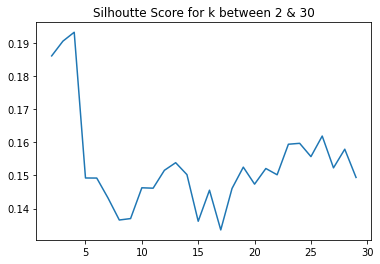

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
score={}
for k in range(2,30):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=3)
    pred = kmeans.fit_predict(X)
    score[k] = silhouette_score(X, kmeans.labels_)
    
sns.lineplot(x =list(score.keys()), y=list(score.values()))
plt.title('Silhoutte Score for k between 2 & 30')

In [31]:
kmeans = KMeans(n_clusters=4, n_init=100)
pred = kmeans.fit_predict(X)
pred

array([2, 1, 0, 2, 0, 1, 0, 1, 1, 3, 0, 0, 1, 0, 0, 2, 0, 1, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0, 3, 1, 2, 0,
       0, 3, 1, 3, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 3, 0, 3, 0, 1,
       0, 0, 1, 0, 3, 3, 0, 3, 1, 0, 0, 1, 0, 2, 1, 3, 1, 0, 1, 1, 3, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0])

In [32]:
df1.insert(0, 'Cluster', pred, True)
df1.reset_index(inplace=True)

In [33]:
df1.groupby(by='Cluster').mean()

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Deli / Bodega,Diner,...,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Turkish Restaurant,Vegetarian / Vegan Restaurant
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.698113,6.566038,0.301887,1.396226,0.981132,1.226415,1.037736,0.867925,0.264151,0.471698,...,1.075472,1.132075,1.452830,1.075472,1.924528,1.320755,0.377358,0.584906,0.509434,0.226415
1,0.958333,3.166667,0.458333,2.166667,0.666667,0.625000,5.083333,0.375000,0.458333,0.458333,...,1.916667,0.875000,0.583333,1.166667,2.000000,0.541667,0.708333,0.166667,0.208333,0.666667
2,0.000000,14.222222,0.333333,2.111111,0.888889,0.666667,1.444444,1.555556,0.000000,0.000000,...,0.222222,0.777778,1.333333,0.555556,0.666667,0.111111,0.666667,0.000000,0.111111,0.222222
3,0.588235,4.823529,0.588235,2.117647,0.647059,0.647059,2.823529,0.352941,0.764706,0.176471,...,6.235294,1.117647,0.823529,1.058824,1.235294,0.352941,0.294118,0.117647,0.176471,0.647059


In [34]:
df1.groupby(by='Cluster').count()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Deli / Bodega,...,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Turkish Restaurant,Vegetarian / Vegan Restaurant
Cluster,,,,,,,,,,,,,,,,,,,,,
0,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
1,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
2,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
3,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
